<a href="https://colab.research.google.com/github/mehdi-or/VT2PFC/blob/main/TRACE_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

Mounted at /content/gdrive


##finction to set the random see for reproducibility purposes

In [ ]:
def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    random.seed(seed_value)  # Python random module
    np.random.seed(seed_value)  # Numpy module
    torch.manual_seed(seed_value)  # PyTorch random number generator for CPU

    # If you are using CUDA
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.

    # Additional configurations to enhance reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

##setting up the architecture of the network

In [ ]:
class DATRACE(nn.Module):
    def __init__(self, VTC_dim, PFC_dim, hidden_dim, bottleneck_dim, num_classes):
        super(DATRACE, self).__init__()
        # Encoding layers for the VTC
        self.encoder_VTC = nn.Linear(VTC_dim, hidden_dim)

        # Shared bottleneck layer
        self.shared_bottleneck = nn.Linear(hidden_dim, bottleneck_dim)

        # Decoding layers for PFC
        self.decoder = nn.Linear(bottleneck_dim, hidden_dim)
        self.prediction_PFC = nn.Linear(hidden_dim, PFC_dim)

        # Classification layer attached to the shared bottleneck
        self.classifier = nn.Linear(bottleneck_dim, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x1):
        # Encoder VTC
        enocded_VTC = torch.tanh(self.encoder_VTC(x1))
        enocded_VTC = self.dropout(enocded_VTC)
        BN_shared = torch.tanh(self.shared_bottleneck(enocded_VTC))
        # Decoder PFC
        decoded = torch.tanh(self.decoder(BN_shared))
        predicted_PFC = self.prediction_PFC(decoded)

        # Classifier
        logits = self.classifier(BN_shared)
        probabilities = logits

        return predicted_PFC, probabilities

# logistic classifier
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

#correlation custom loss function
class CorrelationLoss(torch.nn.Module):
    def __init__(self):
        super(CorrelationLoss, self).__init__()

    def forward(self, x, y):
        # Ensure input is float for accurate mean and std calculations
        x = x.float()
        y = y.float()

        # Mean and standard deviation along the trials dimension
        x_mean = x.mean(dim=1, keepdim=True)
        y_mean = y.mean(dim=1, keepdim=True)
        x_std = x.std(dim=1, keepdim=True)
        y_std = y.std(dim=1, keepdim=True)

        # Covariance calculation
        covariance = ((x - x_mean) * (y - y_mean)).mean(dim=1)
        # Avoid division by zero
        eps = 1e-8
        correlation = covariance / (x_std * y_std + eps)

        # Negative mean correlation across all samples and features
        mean_correlation = correlation.mean()
        return -mean_correlation

##importing the data

In [ ]:
def load_data_VTC(subject):
    with h5py.File(r'/content/gdrive/MyDrive/Colab Notebooks/CNC data/hrfAll_VT_PETERS.hdf5', 'r') as hdf:
        data0 = hdf.get('items/'+str(subject)+'/rcargs/items/0')
        data_vtc = np.array(data0)
        data_vtc = np.delete(data_vtc,np.where(~data_vtc.any(axis=0))[0],axis=1)
    return(data_vtc)

def load_data_PFC(subject):
    with h5py.File(r'/content/gdrive/MyDrive/Colab Notebooks/CNC data/hrfAll_DLPFC_PETERS.hdf5', 'r') as hdf:
        data0_pfc = hdf.get('items/'+str(subject)+'/rcargs/items/0')
        data_pfc = np.array(data0_pfc)
        data_pfc = np.delete(data_pfc,np.where(~data_pfc.any(axis=0))[0],axis=1)
    return(data_pfc)

def preprocessign (data, labels2categ, shuffle_index):
  data_train, data_test, y_categ_train, y_categ_test, map_train_index, map_test_index = train_test_split(data, labels2categ, shuffle_index, random_state=42)
  #scaler = StandardScaler()
  scaler = MinMaxScaler(feature_range=(-1,1))
  X_train = scaler.fit_transform(data_train)
  X_test = scaler.transform(data_test)
  return X_train, X_test, y_categ_train, y_categ_test, map_train_index, map_test_index

#setting the labels for pytorch is differen from keras
# the way it works is that we need to assign a number to each categorical class
unique_labels = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CNC data/unique_aranged.csv', header=None).values[:,1]
labels = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/CNC data/label.csv')['y'].values
label_to_index = {label: idx for idx, label in enumerate(unique_labels)} #mapping form label to its numeric value
index_to_label = {idx: label for label, idx in label_to_index.items()} #mapping from numeric label to the name of the label

#turning label file into its numeric values
numeric_labels = []
for label in labels:
  numeric_labels.append(label_to_index[label])

numeric_labels = np.array(numeric_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#converting all the numpy array inot pytorch tensor

VTC0 = load_data_VTC(37)
#VTC0 = np.random.normal(0,1, (3600, 2450)) #giving random noise as VTC data
PFC0 = load_data_PFC(37)
VTC_dim = VTC0.shape[1]
PFC_dim = PFC0.shape[1]
num_classes = len(np.unique(labels))
shuffle_index = np.arange(0,3600)
VTC_train, VTC_test, y_train, y_test, map_train_index, map_test_index = preprocessign(VTC0, numeric_labels, shuffle_index)
PFC_train, PFC_test, _, _, _, _ = preprocessign(PFC0, numeric_labels, shuffle_index)

VTC_tensor_train = torch.tensor(VTC_train, dtype=torch.float32).to(device)
VTC_tensor_test = torch.tensor(VTC_test, dtype=torch.float32).to(device)
PFC_tensor_train = torch.tensor(PFC_train, dtype=torch.float32).to(device)
PFC_tensor_test = torch.tensor(PFC_test, dtype=torch.float32).to(device)
y_tensor_train = torch.tensor(y_train)
y_tensor_test =torch.tensor(y_test)

train_dataset = TensorDataset(VTC_tensor_train, PFC_tensor_train, y_tensor_train)
test_dataset = TensorDataset(VTC_tensor_test, PFC_tensor_test, y_tensor_test)

# for spliting the train and test set for "seperate-classifier" evaluaton
def make_dataloader(VTC_test, PFC_test, y_test):
  trainidx = int(VTC_test.shape[0]*0.8)
  VTC_test_train, VTC_test_test = VTC_test[:trainidx,:], VTC_test[trainidx:,:]
  PFC_test_train, PFC_test_test = PFC_test[:trainidx,:], PFC_test[trainidx:,:]
  y_test_train, y_test_test = y_test[:trainidx], y_test[trainidx:]

  VTC_tensor_test_train = torch.tensor(VTC_test_train, dtype=torch.float32).to(device)
  VTC_tensor_test_test = torch.tensor(VTC_test_test, dtype=torch.float32).to(device)
  PFC_tensor_test_train = torch.tensor(PFC_test_train, dtype=torch.float32).to(device)
  PFC_tensor_test_test = torch.tensor(PFC_test_test, dtype=torch.float32).to(device)
  y_tensor_test_train = torch.tensor(y_test_train)
  y_tensor_test_test =torch.tensor(y_test_test)

  test_train_dataset = TensorDataset(VTC_tensor_test_train, PFC_tensor_test_train, y_tensor_test_train)
  test_test_dataset = TensorDataset(VTC_tensor_test_test, PFC_tensor_test_test, y_tensor_test_test)

  test_train_loader = DataLoader(test_train_dataset, batch_size=64, shuffle=True)
  test_test_loader = DataLoader(test_test_dataset, batch_size=64, shuffle=False)
  return test_train_loader, test_test_loader, VTC_tensor_test_test, PFC_tensor_test_test, y_tensor_test_test

##Function for calculating the metrics


In [ ]:
def fidelity(x, x_pred):
  #x = x.detach().numpy()
  #x_pred = x_pred.detach().numpy()
  #calculating recons fidelity
  corr_x = np.corrcoef(x, x_pred)[:x.shape[0],x.shape[0]:]
  corr_x = np.diag(corr_x)
  recons_fidelity = np.mean(corr_x)
  return recons_fidelity

def log_classifier(model, train_loader, val_loader, epochs=10):
    # Initializing the criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    for epoch in range(epochs):
        set_seed(42 + epoch)
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
    accur = val_correct / val_total
    return model, accur


## function for training the model

In [ ]:
#train and val the network
def train_and_val_network (train_loader, val_loader, num_classes=40, BN_dim=30, num_epochs=300, alpha=0.1):
  data_iterator = iter(val_loader)
  input_VTC, input_PFC, labels = next(data_iterator)
  VTC_dim = input_VTC.shape[1]
  input_PFC = input_PFC.shape[1]

  # Define the model, optimizer, and loss functions
  model = DATRACE(VTC_dim=VTC_dim, PFC_dim=PFC_dim, hidden_dim=500, bottleneck_dim=BN_dim, num_classes=num_classes)
  optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
  #mse_loss_fn = nn.MSELoss()
  mse_loss_fn = nn.L1Loss()
  #mse_loss_fn = CorrelatonLoss()
  classification_loss_fn = nn.CrossEntropyLoss()
  train_loss_PFC_hist = []
  train_loss_class_hist = []
  val_PFC_loss_hist = []
  train_loss_hist = []
  val_loss_hist = []
  for epoch in range(num_epochs):
      train_loss = 0
      predicted_loss_PFC = 0
      classification_loss = 0
      set_seed(42 + epoch)
      model.train()
      for input_VTC, input_PFC, labels in train_loader:
          optimizer.zero_grad()
          predicted_PFC, probabilities = model(input_VTC)
          # Calculate losses
          predicted_loss_PFC0 = mse_loss_fn(predicted_PFC, input_PFC)
          classification_loss0 = classification_loss_fn(probabilities, labels)
          # Total loss
          total_loss = predicted_loss_PFC0 + alpha*classification_loss0
          # Backpropagation and optimizer step
          total_loss.backward()
          optimizer.step()
          predicted_loss_PFC += predicted_loss_PFC0.item()
          classification_loss += classification_loss0.item()
          train_loss += total_loss.item()
      predicted_loss_PFC /= len(train_loader)
      classification_loss /= len(train_loader)
      train_loss /= len(train_loader)
      train_loss_PFC_hist.append(predicted_loss_PFC)
      train_loss_class_hist.append(classification_loss)
      train_loss_hist.append(train_loss)

      # Validation
      model.eval()
      val_loss = 0
      val_PFC_loss = 0
      with torch.no_grad():
          for input_VTC, input_PFC, labels in val_loader:
              reconstructed, probabilities = model(input_VTC)
              PFC_loss = mse_loss_fn(reconstructed, input_PFC)
              classification_loss = classification_loss_fn(probabilities, labels)
              loss = PFC_loss + alpha*classification_loss
              val_PFC_loss += PFC_loss.item()
              val_loss += loss.item()

      val_PFC_loss /= len(val_loader)
      val_loss /= len(val_loader)
      val_PFC_loss_hist.append(val_PFC_loss)
      val_loss_hist.append(val_loss)

      if (epoch+1)%(num_epochs/10)==0:
        print(f"Epoch {epoch+1}/{num_epochs} completed for alpha={alpha}.")
  return model, train_loss_hist, val_loss_hist


# writting a for loop to run the model for different bottleneck dimensions
# And calculating the metrics we want
set_seed(42) # to get the same training and testset everytime
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

test_train_loader, test_test_loader,_, PFC_tensor_test_test, y_tensor_test_test = make_dataloader(VTC_test, PFC_test, y_test)
#test_train_loader = DataLoader(test_train_dataset, batch_size=64, shuffle=True)
#test_test_loader = DataLoader(test_test_dataset, batch_size=64, shuffle=False)

alpha = 0.1 # Classifier weigth of the network
num_epochs = 300
num_classes = 40
BN_dims = [20, 50, 200, 300, 500]
accuracies = []
pfc_fidels = []
for BN_dim in BN_dims:
  model, train_loss_hist, val_loss_hist = train_and_val_network(train_loader, val_loader, num_classes, BN_dim, num_epochs, alpha)
  # Fetch a batch of test images
  predicted_pfc, pred_labels = model(VTC_tensor_test)
  predicted_pfc = predicted_pfc.detach().numpy()

  # training the seperate classifier
  trainidx = int(VTC_test.shape[0]*0.8)
  PFC_test_train, PFC_test_test = predicted_pfc[:trainidx,:], predicted_pfc[trainidx:,:]
  y_test_train, y_test_test = y_test[:trainidx], y_test[trainidx:]
  PFC_tensor_test_train = torch.tensor(PFC_test_train, dtype=torch.float32).to(device)
  PFC_tensor_test_test = torch.tensor(PFC_test_test, dtype=torch.float32).to(device)
  y_tensor_test_train = torch.tensor(y_test_train)
  y_tensor_test_test =torch.tensor(y_test_test)
  test_train_dataset = TensorDataset(PFC_tensor_test_train, y_tensor_test_train)
  test_test_dataset = TensorDataset(PFC_tensor_test_test, y_tensor_test_test)
  test_train_loader = DataLoader(test_train_dataset, batch_size=64, shuffle=True)
  test_test_loader = DataLoader(test_test_dataset, batch_size=64, shuffle=False)

  classifier = LogisticRegression(PFC_dim, num_classes)
  classifier_trained = log_classifier(classifier, test_train_loader, test_test_loader, epochs=num_epochs)
  outputs, accu = classifier_trained(PFC_tensor_test_test)
  val_total = y_tensor_test_test.size(0)
  _, predicted = torch.max(outputs.data, 1)
  val_correct = (predicted == y_tensor_test_test).sum().item()
  accuracy = val_correct/val_total
  accuracies.append(accuracy)

  pfc_fidel = fidelity(PFC_test[trainidx:,:], PFC_test_test)
  pfc_fidels.append(pfc_fidel)


print(predicted_pfc.shape)
'''
# 4. Plotting the loss evolution
plt.figure(figsize=(10, 5))
plt.plot(train_loss_PFC_hist, label='Training PFC')
plt.plot(train_loss_class_hist, label='Training classifier')
'''
plt.plot(train_loss_hist, label='Training Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Evolution')
plt.show()

In [19]:
accuracies

[0.6555555555555556, 0.7055555555555556, 0.65, 0.6, 0.5555555555555556]

In [ ]:
accuracy

0.2111111111111111

In [20]:
pfc_fidels

[0.5524464499487045,
 0.6869093810127025,
 0.7834357335593011,
 0.8107217315896068,
 0.8331365428775155]

In [ ]:
set_seed(42)
classifier = LogisticRegression(PFC_dim, num_classes)
classifier_trained, accur = log_classifier(classifier, test_train_loader, test_test_loader, epochs=30)
outputs = classifier_trained(PFC_tensor_test_test) #classifier always takes PFC here
_, predicted = torch.max(outputs.data, 1)
val_total = y_tensor_test_test.size(0)
val_correct = (predicted == y_tensor_test_test).sum().item()
accuracy = val_correct/val_total
accuracy

0.2

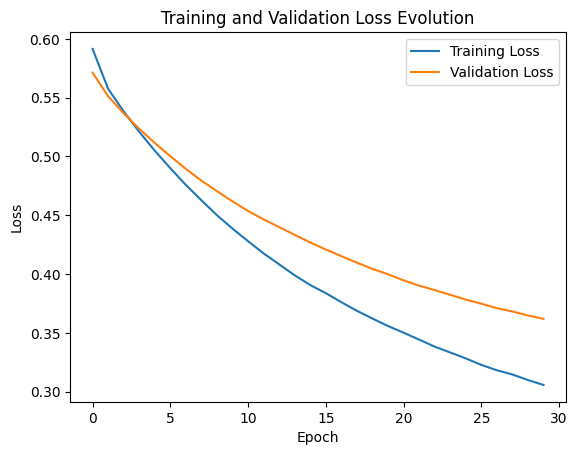

In [ ]:
plt.plot(train_loss_hist, label='Training Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Evolution')
plt.show()

##plotting the loss functions

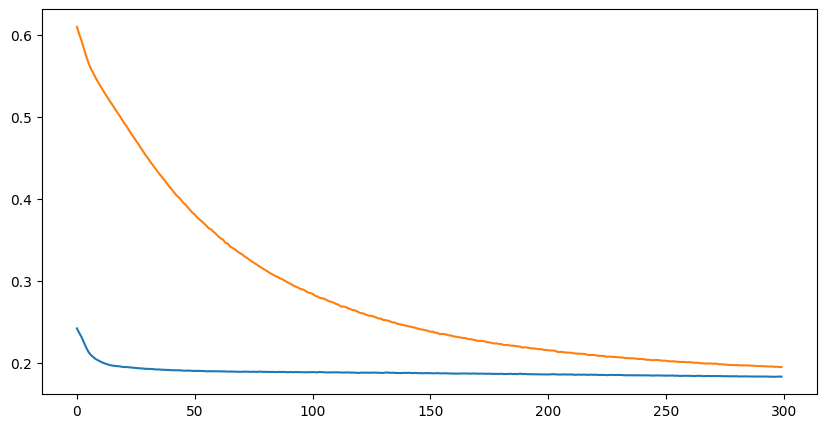

In [ ]:

# 4. Plotting the loss evolution
plt.figure(figsize=(10, 5))
plt.plot(train_loss_PFC_hist[-300:], label='Training PFC')
#plt.plot(train_loss_class_hist, label='Training classifier')
plt.plot(train_loss_hist[-300:], label='Training Loss')
#plt.plot(val_loss_history, label='Validation Loss')

In [ ]:
for i, loss in enumerate(best_alpha):
  print(loss)
  plt.plot(loss[-300:], label=alphas[i])
plt.legend()